## 1. Setup

In [89]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [90]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [91]:
data_dir = os.path.join("new_data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_images_dir = os.path.join(train_dir, "images")
train_masks_dir = os.path.join(train_dir, "masks")
val_images_dir = os.path.join(val_dir, "images")
val_masks_dir = os.path.join(val_dir, "masks")
train_fns = os.listdir(train_images_dir)
val_fns = os.listdir(val_images_dir)
print(len(train_fns), len(val_fns))

572 143


## 2. Analyze data

new_data\train\images\0000047.jpg


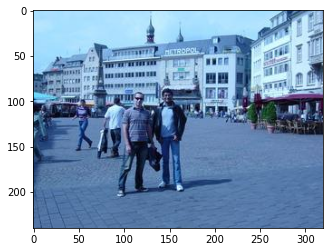

In [92]:
sample_image_fp = os.path.join(train_images_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

new_data\train\masks\0000047.png


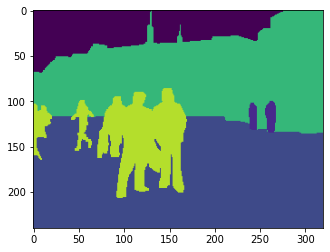

In [93]:
sample_mask_fp = os.path.join(train_masks_dir, train_fns[0].replace('jpg', 'png'))
sample_mask = Image.open(sample_mask_fp).convert("RGB")
plt.imshow(sample_mask)
print(sample_mask_fp)

(240, 320, 3)
0 255 1 222


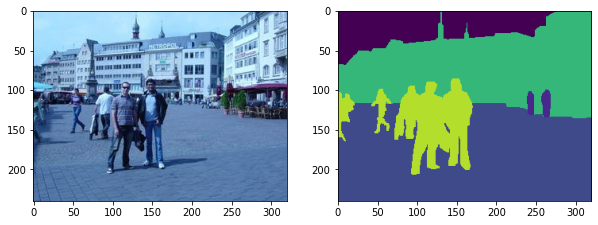

In [94]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = np.array(sample_image), np.array(sample_mask)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

## 3. Define Labels

In [95]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)

    plt.savefig('visualization.png')

In [96]:
# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and height as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [97]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and height as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis=-1)
    return x


In [98]:
DATA_DIR = 'data'
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'labels_class_dict.csv'))
# Get class names
class_names = class_dict['class_names'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

image_names = os.listdir(os.path.join(DATA_DIR, 'images'))
image_paths = [os.path.join(DATA_DIR, 'images', image_name) for image_name in image_names]
mask_paths = [os.path.join(DATA_DIR, 'masks', image_name.replace('jpg', 'png')) for image_name in image_names]

# example code to read one image and its corresponding mask
example_index = 0

image0 = cv2.cvtColor(cv2.imread(image_paths[0]), cv2.COLOR_BGR2RGB)
mask0 = cv2.cvtColor(cv2.imread(mask_paths[0]), cv2.COLOR_BGR2RGB)

# visualize(original_image=image0, mask=mask0)

mask0 = one_hot_encode(mask0, class_rgb_values).astype('float')

print('Image shape: ', image0.shape)
print('Mask shape: ', mask0.shape)
print(class_names, class_rgb_values)

# 有用的内容： class_names, class_rgb_values

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']
Class RGB values:  [[68, 1, 84], [72, 40, 140], [62, 74, 137], [38, 130, 142], [31, 158, 137], [53, 183, 121], [109, 205, 89], [180, 222, 44], [49, 104, 142]]
Image shape:  (240, 320, 3)
Mask shape:  (240, 320, 9)
['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown'] [[68, 1, 84], [72, 40, 140], [62, 74, 137], [38, 130, 142], [31, 158, 137], [53, 183, 121], [109, 205, 89], [180, 222, 44], [49, 104, 142]]


## 4. Define Dataset

In [107]:
class MyDataset(Dataset):

    def __init__(self, images_dir, masks_dir, class_names_, class_rgb_values_):
        self.Size = (256, 256)
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_fns = os.listdir(images_dir)
        self.mask_fns = os.listdir(masks_dir)
        if len(self.image_fns) != len(self.mask_fns):
            raise Exception("length of image and mask are not equal!")
        self.class_names = class_names_
        self.class_rgb_values = class_rgb_values_
        if len(self.class_names) != len(self.class_rgb_values):
            raise Exception("length of class_names and class_rgb_values are not equal!")
        self.image_paths = [os.path.join(self.images_dir, image_name) for image_name in self.image_fns]
        self.mask_paths = [os.path.join(self.masks_dir, image_name) for image_name in self.mask_fns]
        # print(self.image_paths, self.mask_paths)
        self.images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in self.image_paths]
        self.masks = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in self.mask_paths]
        self.masks = [one_hot_encode(mask, self.class_rgb_values).astype('float') for mask in self.masks]
        self.masks = [reverse_one_hot(mask) for mask in self.masks]

        # print(len(self.masks))
        # print(self.masks[0])
        self.images_processed = [self.transform(x) for x in self.images]
        self.masks_processed = [self.resize_mask(x) for x in self.masks]


    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, index):
        # cityscape, label_class = self.images[index], self.masks[index]
        # cityscape = transform(cityscape)
        # label_class = torch.Tensor(label_class).long()
        return self.images_processed[index], self.masks_processed[index]

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            transforms.Resize(size=self.Size)
        ])
        return transform_ops(image)

    def resize_mask(self, x):
        y = torch.Tensor(x).long()
        y = y.unsqueeze(0) # 升一维
        mask_transform = transforms.Resize(size=self.Size)
        y = mask_transform(y)
        y = y.squeeze(0) # 还原维度
        return y


    # def split_image(self, image):
    #     image = np.array(image)
    #     cityscape, label = image[:, :256, :], image[:, 256:, :]
    #     return cityscape, label

In [108]:
%%time
dataset = MyDataset(train_images_dir, train_masks_dir, class_names, class_rgb_values)
print(len(dataset))

572
CPU times: total: 12.7 s
Wall time: 11.6 s


In [109]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


## 5. Define Model

In [110]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X)  # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out)  # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out)  # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out)  # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out)  # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out)  # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out)  # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out)  # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out)  # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out)  # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(
            torch.cat((expansive_11_out, contracting_41_out), dim=1))  # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out)  # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(
            torch.cat((expansive_21_out, contracting_31_out), dim=1))  # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out)  # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(
            torch.cat((expansive_31_out, contracting_21_out), dim=1))  # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out)  # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(
            torch.cat((expansive_41_out, contracting_11_out), dim=1))  # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out)  # [-1, num_classes, 256, 256]
        return output_out

In [111]:
model = UNet(num_classes=len(class_names))

In [112]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).__next__()
print(X.shape, Y.shape)

572 143
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [113]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 9, 256, 256])


## 6. Train the model

In [114]:
batch_size = 16

epochs = 10
lr = 0.01

In [115]:
dataset = MyDataset(train_images_dir, train_masks_dir, class_names, class_rgb_values)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [116]:
model = UNet(num_classes=len(class_names)).to(device)

In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [118]:
print(dataset.images_processed[7].shape)

torch.Size([3, 256, 256])


In [119]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss / len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 6.00 GiB total capacity; 4.97 GiB already allocated; 0 bytes free; 5.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [ ]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

## 7. Check model predictions